# Advanced Lane Line Finding

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os.path
from tqdm import tqdm

%matplotlib inline


class LaneFinder():
    """Finds laneline inside car camera images"""
    def __init__(self):
        self.width = 1280
        self.height = 720
        self.left_fit = None
        self.right_fit = None
        
    def calibrate_camera(self, force=False):
        """Calculate the camera distortion matrix"""
        # camera distortion matrix pickle file
        dist_mtx_file = 'distort_mtx.p'
        # calibration images glob
        chessboard_images = './camera_cal/*.jpg'
                
        if os.path.isfile(dist_mtx_file) and not force:
            print('Found calculated camera matrix')
            # load camera distortion matrix if already exists
            dist_pickle = pickle.load(open(dist_mtx_file, 'rb'))
            self.camera = {
                'mtx': dist_pickle['mtx'],
                'dist': dist_pickle['dist'],
            }
        else:
            print('Calibrating camera matrix ...\n')
            nx, ny = 9, 5
            objp = np.zeros((nx*ny, 3), np.float32)
            objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
            objpoints = []  # 3D coord in real world
            imgpoints = []  # 2D coord in image plane

            calibration_img_paths = glob.glob(chessboard_images)
            for img_path in tqdm(calibration_img_paths):
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
                if ret == True:
                    objpoints.append(objp)
                    imgpoints.append(corners)

            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
                objpoints, imgpoints, img_size, None, None)

            # Save the camera calibration result for later use
            self.camera = {
                'mtx': mtx,
                'dist': dist,
            }
            print('Camera matrix %s saved for later use')
            print('run calibrate_camera(force=True) to force recalibrate')
            pickle.dump(self.camera, open(dist_mtx_file, 'wb'))

    def undistort(self, img):
        """Undistort image using camera matrix"""
        assert 'mtx' in self.camera
        assert 'dist' in self.camera
        mtx = self.camera['mtx']
        dist = self.camera['dist']
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        return undist

    def s_magnitude(self, img, thresh=(190, 255)):
        """Returns magnitude thresholded binary image of 
        the S channel in HLS color space
        """
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_channel = hls[:,:,2]
        magnitude_binary = np.zeros_like(s_channel)
        magnitude_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
        return magnitude_binary 
        
    def l_direction(self, img, sobel_kernel=9, m_thresh=(40, 255), d_thresh=(0.6, 1.36)):
        """Returns the sobel magnitude and direction thresholded
        binary image of the L channel in HLS color space
        """
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_channel = hls[:,:,1]

        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled = np.uint8(255*magnitude/np.max(magnitude))
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        direction = np.arctan2(abs_sobely, abs_sobelx)
        binary_output = np.zeros_like(direction)
        binary_output[
            (direction >= d_thresh[0])&(direction <= d_thresh[1])&
            (scaled >= m_thresh[0])&(scaled <= m_thresh[1])] = 1
        return binary_output
    
    def combined_thresholding(self, img):
        """Returns the combined result of all thresholdings"""
        s_mag = self.s_magnitude(img)
        l_dir = self.l_direction(img)
        combined_binary = np.zeros_like(img[:,:,1])
        combined_binary[(s_mag == 1) | (l_dir == 1)] = 1
        return combined_binary 
    
    def get_perspective_transform_matrix(self, reverse=False):
        tls = (563, 470)  # top left source point
        bls = (220, 700)  # bottom left source point
        tld = (300, 300)  # top left destination 
        bld = (300, 720)  # bottom left destination
        
        src = np.float32([
            [tls[0], tls[1]],
            [self.width-tls[0], tls[1]],
            [self.width-bls[0], bls[1]],
            [bls[0], bls[1]],
        ])

        dst = np.float32([
            [tld[0], tld[1]],
            [self.width-tld[0], tld[1]],
            [self.width-tld[0], bld[1]],
            [bld[0], bld[1]],
        ])
        
        if reverse:
            transform_mtx = cv2.getPerspectiveTransform(dst, src)
        else:
            transform_mtx = cv2.getPerspectiveTransform(src, dst)
        return transform_mtx
    
    def perspective_transform(self, img, reverse=False):
        """Transform car camera image into birds eye view"""
        transform_mtx = self.get_perspective_transform_matrix(reverse=reverse)
        shape = (self.width, self.height)
        warped = cv2.warpPerspective(
            img, transform_mtx, shape, flags=cv2.INTER_LINEAR)
        return warped
    
    def find_lines(self, binary_warped):
        """Find left/right lane lines from the binary warped inage"""
        width, height = self.width, self.height
        histogram = np.sum(binary_warped[int(height/2):,:], axis=0)
        
        midpoint = np.int(width/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9
        window_height = np.int(height/nwindows)

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []

        margin = 100  # half window size
        minpix = 150   # least pixels to be recognized as found

        for window in range(nwindows):
            win_y_low = height - (window+1)*window_height
            win_y_high = height - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            good_left_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = (
                (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # fit line with with curve
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)

        return self.left_fit, self.right_fit
        
        

Found calculated camera matrix


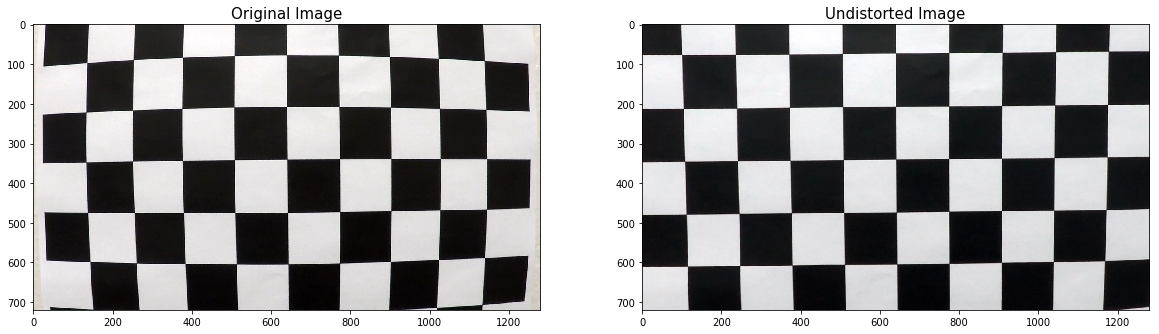

In [2]:
# Test LaneFinder calibration and undistort method
lf = LaneFinder()
lf.calibrate_camera()
img = cv2.imread('./camera_cal/calibration1.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = lf.undistort(img)
cv2.imwrite('./output_images/test1_undist.jpg', undist)

# visualize undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=15)


Found calculated camera matrix


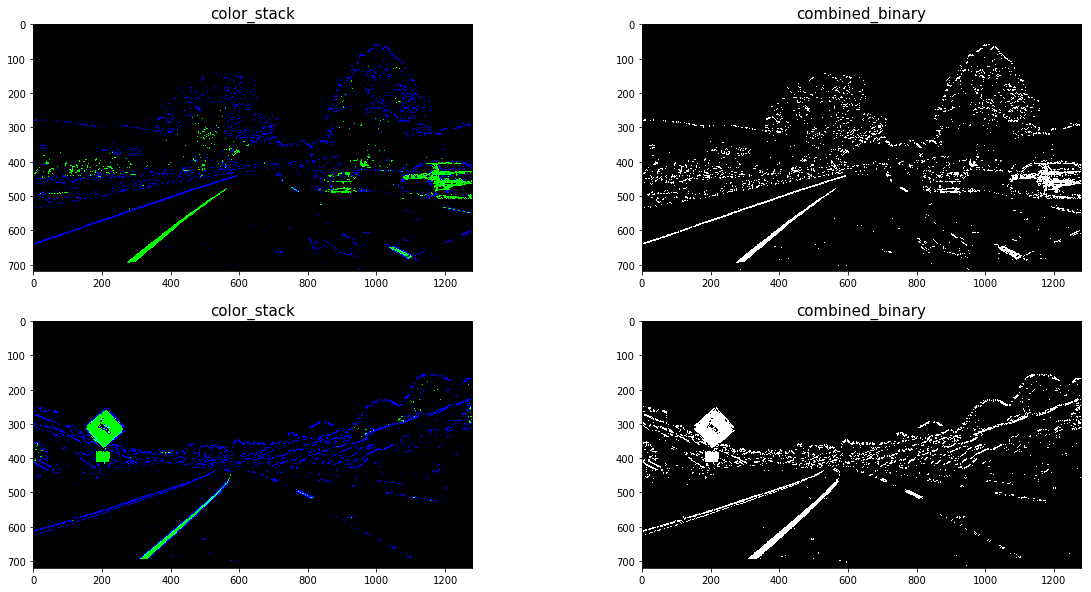

In [3]:
# Tesh LaneFilder thresholding methods
lf = LaneFinder()
lf.calibrate_camera()
num_tests = 2

f, axarr = plt.subplots(num_tests, 2, figsize=(20, 10))
for i in range(num_tests):
    img = cv2.imread('./test_images/test%d.jpg' % (i+1))
    undist = lf.undistort(img)
    s_mag = lf.s_magnitude(undist)
    l_dir = lf.l_direction(undist)
    
    color_stack = np.dstack(( np.zeros_like(s_mag), s_mag, l_dir))
    combined_binary = lf.combined_thresholding(undist)

    # plot the result images
    axarr[i, 0].imshow(color_stack)
    axarr[i, 0].set_title('color_stack', fontsize=15)

    axarr[i, 1].imshow(combined_binary, cmap='gray')
    axarr[i, 1].set_title('combined_binary', fontsize=15)


Found calculated camera matrix


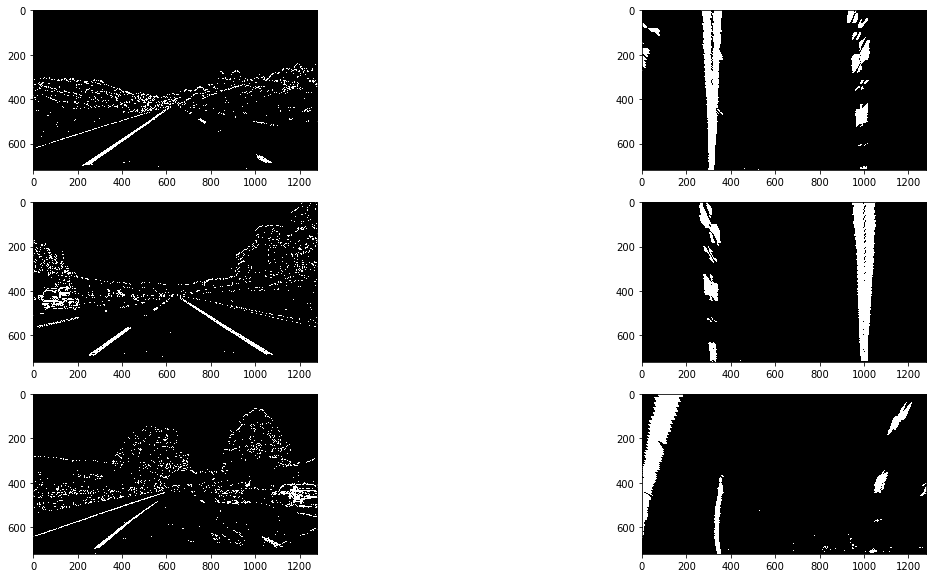

In [4]:
# Test LaneFinder perspective transform
lf = LaneFinder()
lf.calibrate_camera()
test_images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
]

f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 10))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    combined_binary = lf.combined_thresholding(undist)
    warped = lf.perspective_transform(combined_binary)
    axarr[idx][0].imshow(combined_binary, cmap='gray')
    axarr[idx][1].imshow(warped, cmap='gray')

Found calculated camera matrix


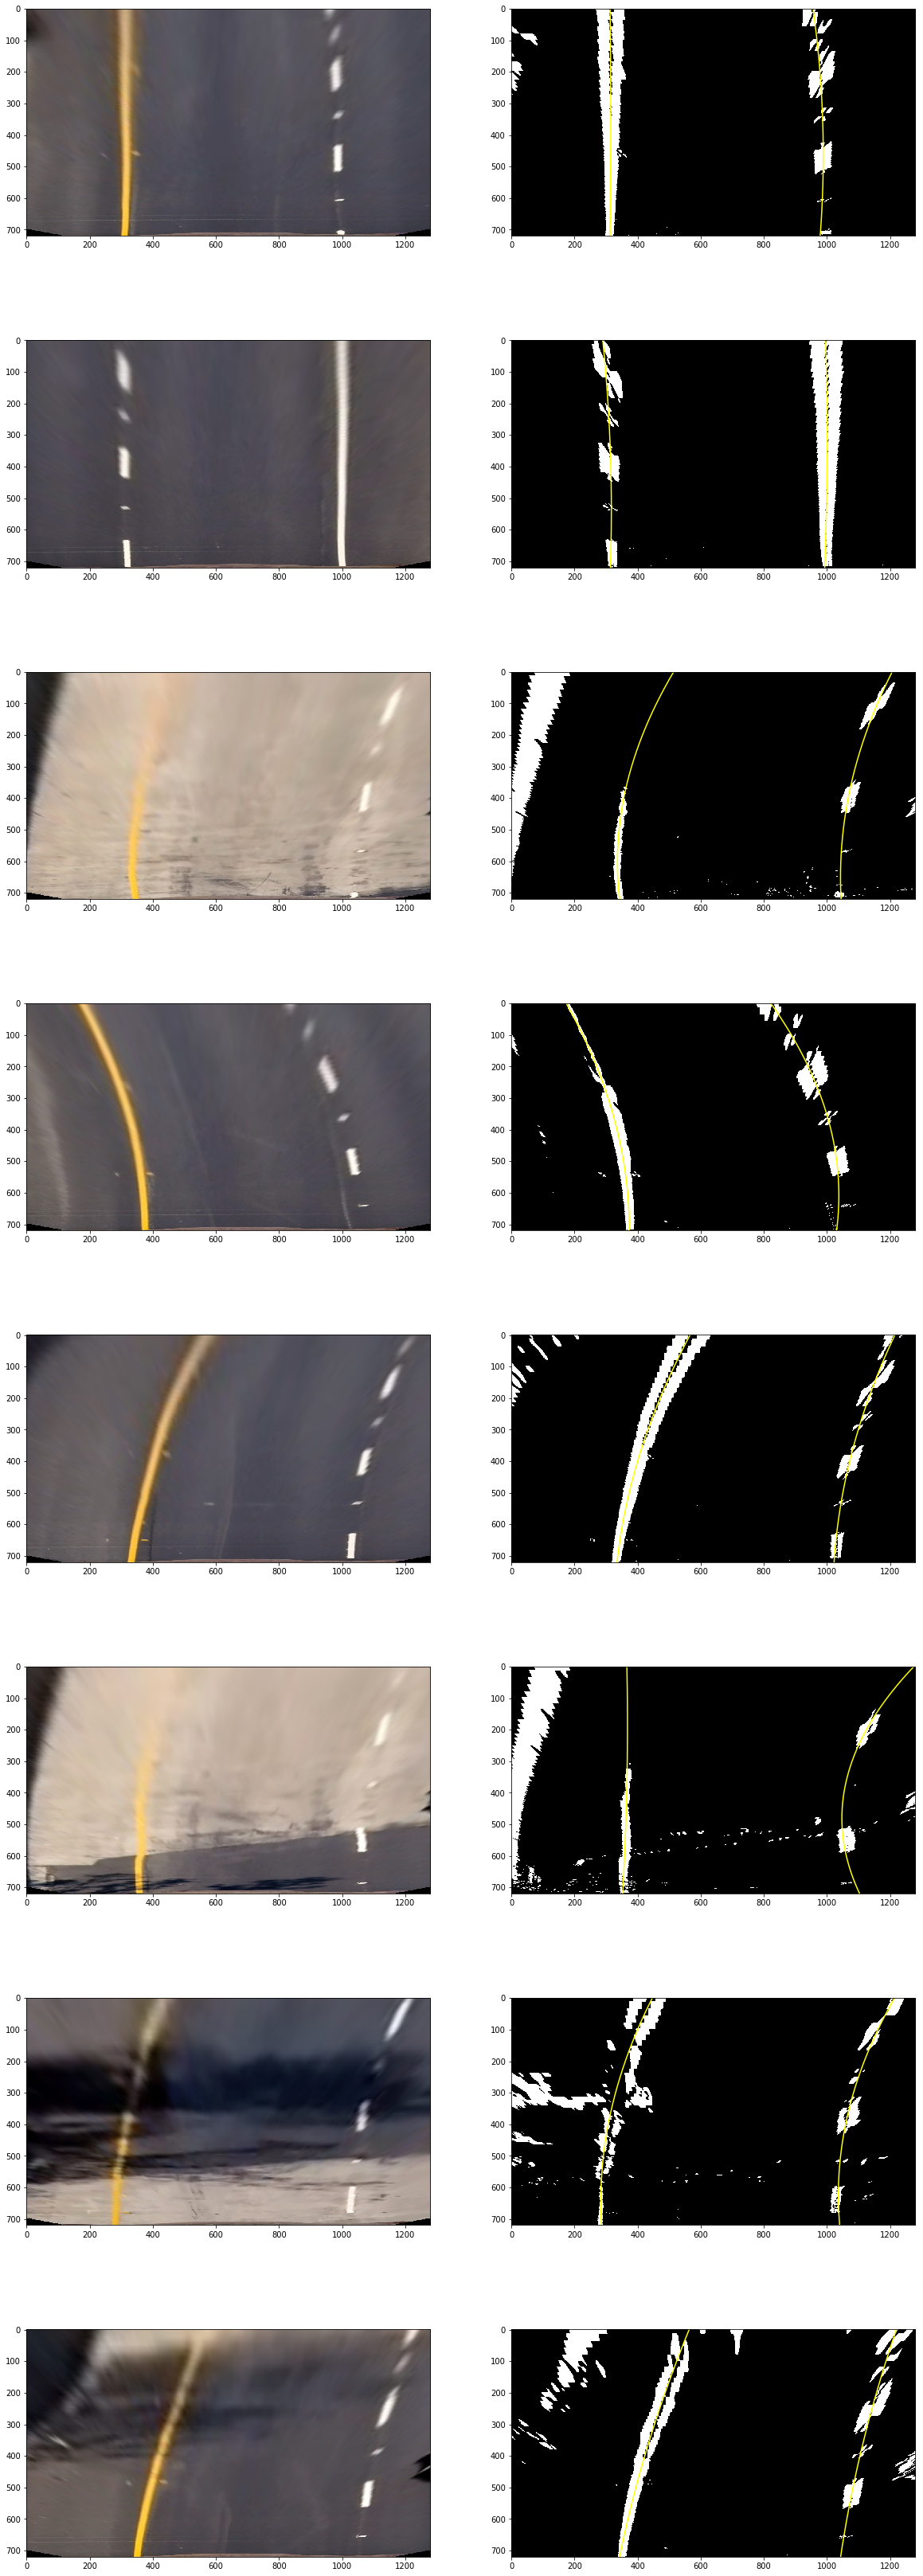

In [5]:
# Test LaneFinder find_line
lf = LaneFinder()
lf.calibrate_camera()
test_images = [
    './test_images/straight_lines1.jpg',
    './test_images/straight_lines2.jpg',
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg',
]

f, axarr = plt.subplots(len(test_images), 2, figsize=(20, 60))
for idx, img_path in enumerate(test_images):
    img = cv2.imread(img_path)
    undist = lf.undistort(img)
    combined_binary = lf.combined_thresholding(undist)
    warped = lf.perspective_transform(combined_binary)
    left_fit, right_fit = lf.find_lines(warped)
    
    # visualize found line
    ploty = np.linspace(0, lf.height-1, lf.height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    rgb = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    rgb_warped = lf.perspective_transform(rgb)
    axarr[idx][0].imshow(rgb_warped)
    
    out_img = np.dstack((warped, warped, warped))*255
    axarr[idx][1].imshow(out_img)
    axarr[idx][1].plot(left_fitx, ploty, color='yellow')
    axarr[idx][1].plot(right_fitx, ploty, color='yellow')
#     axarr[idx][1].xlim(0, 1280)
#     axarr[idx][1].ylim(720, 0)